In [4]:
import os
import pandas as pd
import numpy as np
import calendar
import seaborn as sn
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

### **한글 폰트 사용**

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [9]:
current_dif=os.getcwd()
bike = pd.read_csv(currnet_dif+'\\bike_train.csv')
bike.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### 데이터 설명
- datetime = 시간
- season = 1(봄), 2(여름), 3(가을), 4(겨울)
- holiday = 0(공휴일이 아닌 날), 1(공휴일인 날)
- workingday = 0(휴일), 1(평일)
- weather 
    - 1: (맑음)Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: (안개)Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: (가벼운 눈,비)Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: (무거운 눈,비)Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp = 섭씨 온도
- atemp = 체감 온도
- humidity = 습도
- windspeed = 바람 속도
- casual = 미등록 사용자의 렌탈 건수
- registered = 등록 사용자의 렌탈 건수
- count = 총 렌탈 건수


### **데이터 탐색**

In [10]:
bike['date'] = bike.datetime.apply(lambda x: x.split()[0])
bike['hour'] = bike.datetime.apply(lambda x: x.split()[1].split(":")[0])
bike['weekday'] = bike.date.apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])
bike["month"] = bike.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
bike["season"] = bike.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
bike["weather"] = bike.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                       2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",\
                                       3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",\
                                       4 : " Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog" })

categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    bike[var] = bike[var].astype("category")

bike = bike.drop(["datetime"],axis=1)

#### **1.결측치 확인**

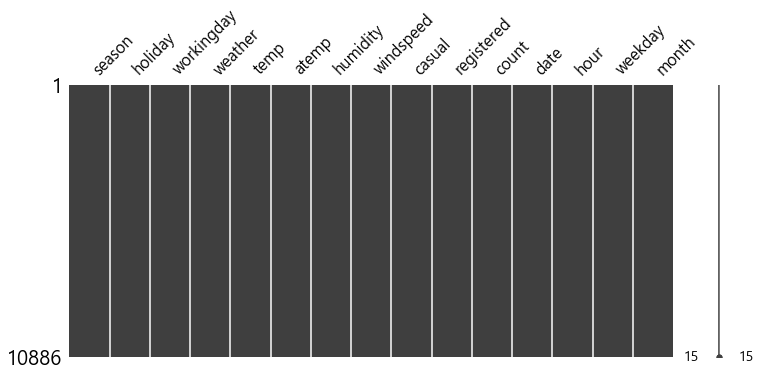

In [11]:
msno.matrix(bike,figsize=(12,5))

#### **2.이상치 확인**

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, '주중/주말'),
 Text(0.5, 1.0, '주중/주말에 따른 렌탈 횟수 박스 플롯')]

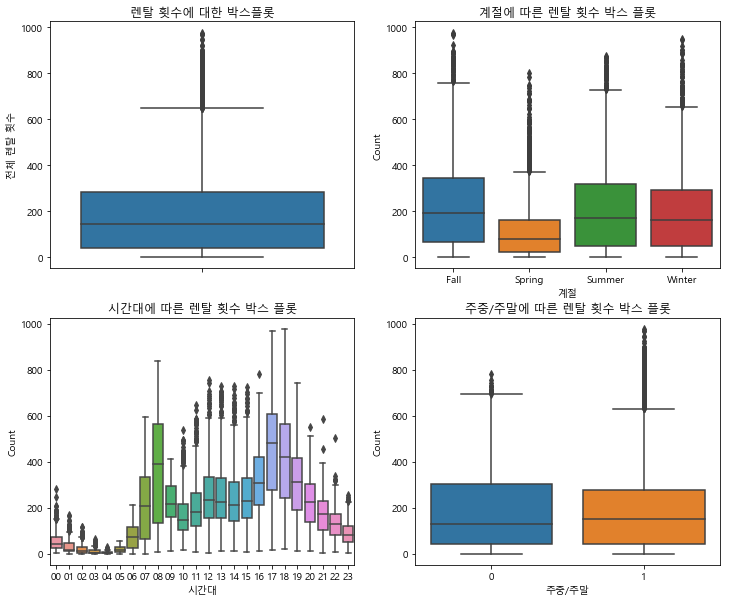

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=bike,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=bike,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=bike,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=bike,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='전체 렌탈 횟수',title="렌탈 횟수에 대한 박스플롯")
axes[0][1].set(xlabel='계절', ylabel='Count',title="계절에 따른 렌탈 횟수 박스 플롯")
axes[1][0].set(xlabel='시간대', ylabel='Count',title="시간대에 따른 렌탈 횟수 박스 플롯")
axes[1][1].set(xlabel='주중/주말', ylabel='Count',title="주중/주말에 따른 렌탈 횟수 박스 플롯")

In [13]:
bikeWithoutOutliers = bike[np.abs(bike["count"]-bike["count"].mean())<=(3*bike["count"].std())] 

In [14]:
print ("Shape Of The Before Ouliers: ",bike.shape)
print ("Shape Of The After Ouliers: ",bikeWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


#### **3.상관관계 분석**

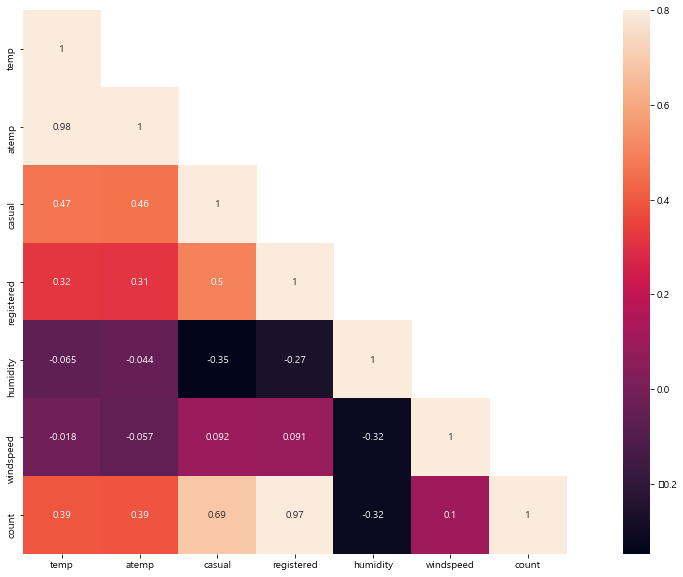

In [15]:
corrMatt = bike[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True, annot=True)

#### **4.count 변수에 대한 시각화**

[Text(0, 0.5, '전체 렌탈 횟수'), Text(0.5, 1.0, 'log 변환(이상치 제거한 Y)')]

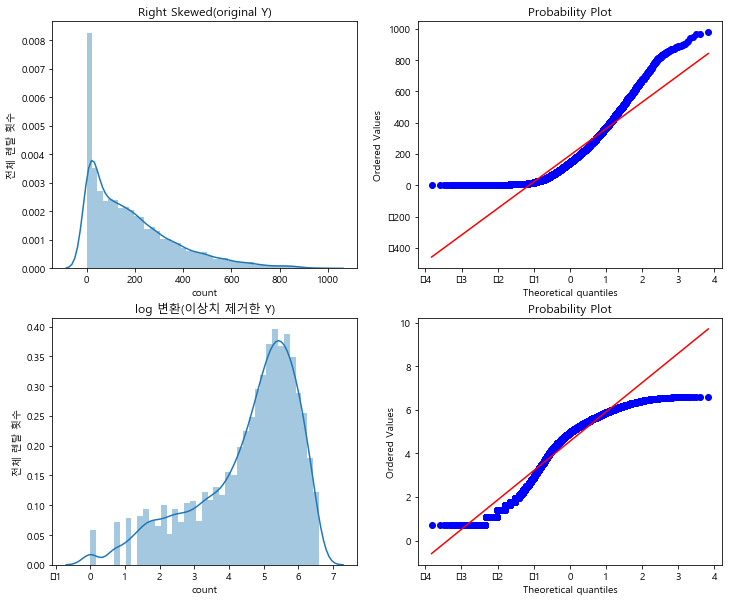

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(12,10)
sn.distplot(bike['count'], ax=axes[0][0])
stats.probplot(bike['count'], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(bikeWithoutOutliers['count']), ax=axes[1][0])
stats.probplot(np.log1p(bikeWithoutOutliers['count']), dist='norm', fit=True, plot=axes[1][1])

axes[0][0].set(ylabel='전체 렌탈 횟수',title="Right Skewed(original Y)")
axes[1][0].set(ylabel='전체 렌탈 횟수',title="log 변환(이상치 제거한 Y)")

#### **5.월별 자전거 렌탈 횟수**

[Text(0, 0.5, '평균 렌탈 횟수'), Text(0.5, 0, '월'), Text(0.5, 1.0, '월별 평균 렌탈 횟수')]

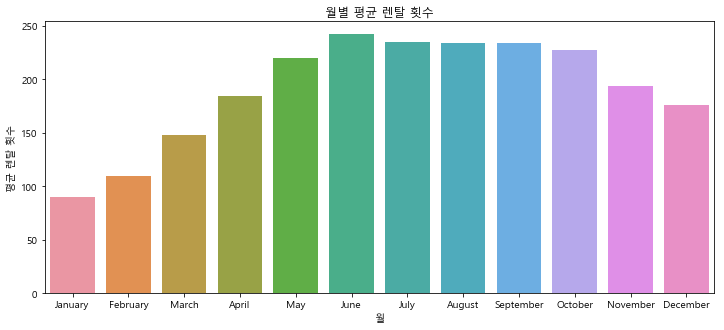

In [61]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
monthAggregated = pd.DataFrame(bike.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.set_palette("husl")
sn.barplot(data=monthSorted,x="month",y="count",order=sortOrder)
ax.set(xlabel='월', ylabel='평균 렌탈 횟수',title="월별 평균 렌탈 횟수")

#### **6. 계절별 자전거 렌탈 횟수**

[Text(0, 0.5, '평균 렌탈 횟수'),
 Text(0.5, 0, '시간대'),
 Text(0.5, 1.0, '계절별 시간대에 따른 렌탈 횟수'),
 None]

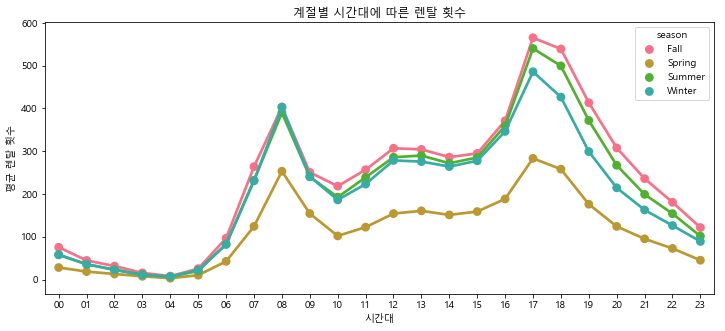

In [63]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
hourAggregated = pd.DataFrame(bike.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"],
              data=hourAggregated,join=True)
ax.set(xlabel='시간대', ylabel='평균 렌탈 횟수',title="계절별 시간대에 따른 렌탈 횟수",label='big')

#### **7.요일별 자전거 렌탈 횟수**

[Text(0, 0.5, '평균 렌탈 횟수'),
 Text(0.5, 0, '시간대'),
 Text(0.5, 1.0, '요일별 시간대에 따른 렌탈 횟수'),
 None]

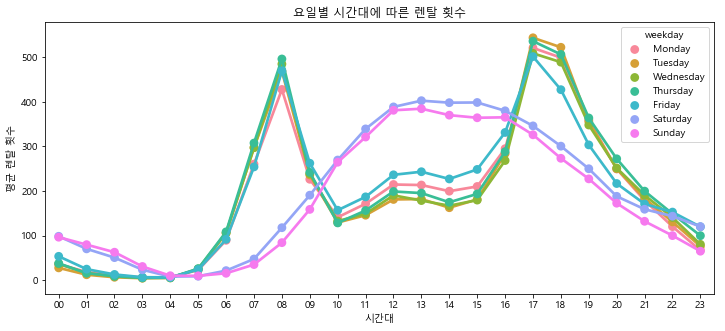

In [24]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
hueOrder = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
hourAggregated = pd.DataFrame(bike.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.set_palette("husl")
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],
             hue_order=hueOrder, data=hourAggregated,join=True)
ax.set(xlabel='시간대', ylabel='평균 렌탈 횟수',title="요일별 시간대에 따른 렌탈 횟수",label='big')

[Text(0, 0.5, '평균 렌탈 횟수'),
 Text(0.5, 0, '시간대'),
 Text(0.5, 1.0, '등록여부별 시간대에 따른 렌탈 횟수'),
 None]

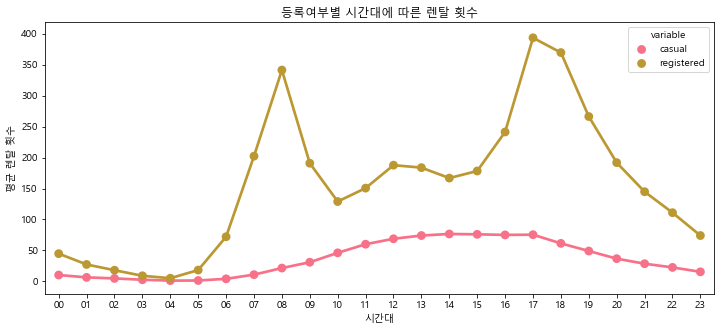

In [29]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
hourTransformed = pd.melt(bike[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True)
ax.set(xlabel='시간대', ylabel='평균 렌탈 횟수',title="등록여부별 시간대에 따른 렌탈 횟수",label='big')

## **자전거 렌탈 예측**

In [33]:
current_dif=os.getcwd()
train= pd.read_csv(currnet_dif+'\\bike_train.csv')
train.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [34]:
train['date']  = train.datetime.apply(lambda x: x.split()[0])
train['hour'] = train.datetime.apply(lambda x: x.split()[1].split(':')[0])
train["year"] = train.datetime.apply(lambda x : x.split()[0].split("-")[0])
train['weekday'] = train.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())
train['month'] = train.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').month)

In [35]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [36]:
for var in categoricalFeatureNames:
    train[var] = train[var].astype("category")

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
datetime      10886 non-null object
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
date          10886 non-null object
hour          10886 non-null category
year          10886 non-null category
weekday       10886 non-null category
month         10886 non-null category
dtypes: category(8), float64(3), int64(4), object(2)
memory usage: 852.8+ KB


In [38]:
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
train_set, test_set = train_test_split(train, test_size=0.25, random_state=99)

In [39]:
train_x = train_set.drop(['casual', 'datetime', 'date', 'registered','count'], axis=1)
train_y = train_set['count']
test_x = test_set.drop(['casual', 'datetime', 'date', 'registered','count'], axis=1)
test_y = test_set['count']

#### **linear regression model**

In [40]:
# 평가방법 - RMSLE(Root Mean Squared Logarithmic Error)
## RMSE와 RMSLE의 차이점 
### RMSLE는 예측값과 실제값의 차이에 대한 비율을 측정(실제값보다 예측값이 낮은 경우 패널티를 가함)
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [41]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
'''import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)'''

LR = LinearRegression()
train_y_log = np.log1p(train_y)
test_y_log = np.log1p(test_y)
LR.fit(X = train_x, y = train_y_log)
preds = LR.predict(X=test_x)
print('RMSLE 값: ',rmsle(np.exp(test_y_log),np.exp(preds),False)) 

RMSLE 값:  0.9762681944426173


#### **ridge model**

In [42]:
def RMSE(y_true, y_perd):
    rmse = metrics.mean_squared_error(y_true, y_pred)
    print('RMSE: %2.3f' % mse**0.5)
    return mse**0.5

In [43]:
ridge = Ridge()
ridge_params = {'max_iter':[3000], 'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30, 50, 100, 200, 400, 800, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5,scoring = rmsle_scorer)
train_y_log = np.log1p(train_y)
test_y_log = np.log1p(test_y)
grid_ridge.fit(train_x, y=train_y_log)
preds = grid_ridge.predict(test_x)
print(grid_ridge.best_params_)
print('RMSLE 값: ', rmsle(np.exp(test_y_log),np.exp(preds),False)) 

{'alpha': 100, 'max_iter': 3000}
RMSLE 값:  0.9761828619679894


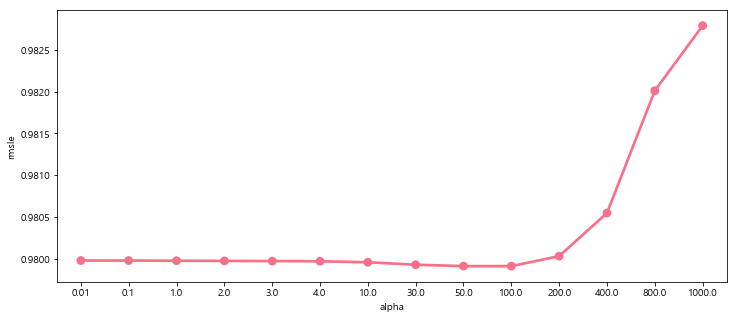

In [44]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax) 

#### **lasso model**

In [45]:
lasso = Lasso()
alpha  = 1/np.array([0.01, 0.1, 1, 2, 3, 4, 10, 30, 50, 100, 200, 400, 800, 1000])
lasso_params_ = {'max_iter':[3000],'alpha':alpha}
grid_lasso = GridSearchCV(lasso,lasso_params_,scoring = rmsle_scorer,cv=5)
train_y_log = np.log1p(train_y)
test_y_log = np.log1p(test_y)
grid_lasso.fit(train_x, train_y_log)
preds = grid_lasso.predict(X= test_x)
print(grid_lasso.best_params_)
print('RMSLE 값: ', rmsle(np.exp(test_y_log),np.exp(preds),False))  

{'alpha': 0.005, 'max_iter': 3000}
RMSLE 값:  0.9759826306287682


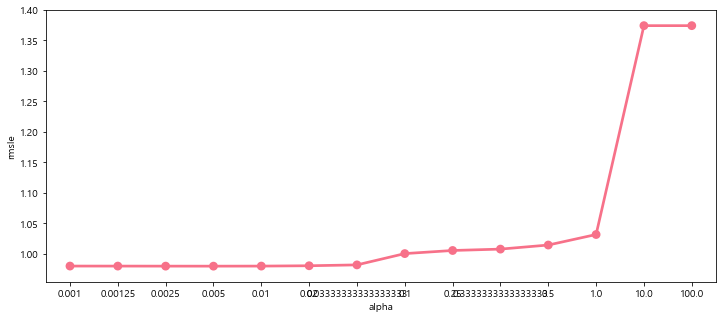

In [46]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax) 

#### **ensemble models - random forest**

In [47]:
from sklearn.ensemble import RandomForestRegressor
rdmForest = RandomForestRegressor(n_estimators=100)
train_y_log = np.log1p(train_y)
test_y_log = np.log1p(test_y)
rdmForest.fit(train_x,train_y_log)
preds = rdmForest.predict(X= test_x)
print('RMSLE 값: ', rmsle(np.exp(test_y_log),np.exp(preds),False)) 

RMSLE 값:  0.28139234224678283


#### **ensemble models - Gradient Boost**

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)
train_y_log = np.log1p(train_y)
test_y_log = np.log1p(test_y)
gbm.fit(train_x,train_y_log)
preds = gbm.predict(X= test_x)
print('RMSLE 값: ', rmsle(np.exp(test_y_log),np.exp(preds),False)) 

RMSLE 값:  0.27029836755864955


[Text(0.5, 1.0, 'predicted y'), None]

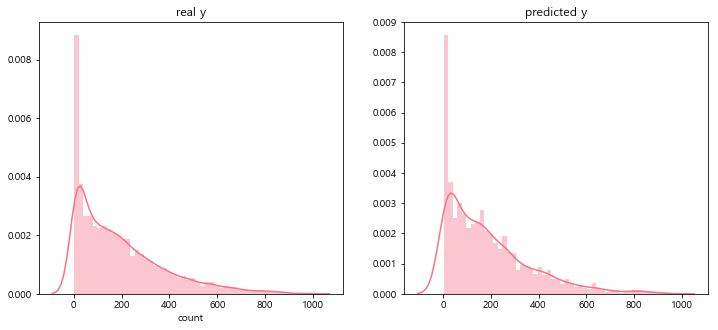

In [53]:
pred_train = gbm.predict(X= train_x)
pred_test = gbm.predict(X= test_x)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot((train_y),ax=ax1,bins=50)
sn.distplot(np.exp(pred_test),ax=ax2,bins=50)
ax1.set(title="real y",label='big')
ax2.set(title="predicted y",label='big')

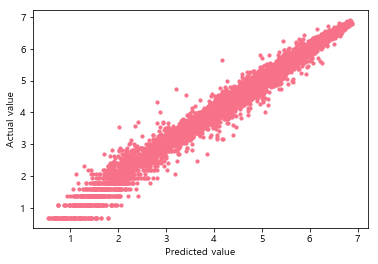

In [54]:
plt.scatter(pred_train, train_y_log, s=10)
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.show()

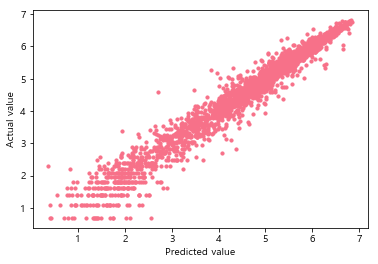

In [55]:
plt.scatter(pred_test, test_y_log, s=10)
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.show() 

In [244]:
datetimecol = test_set["datetime"]
real_count = test_set['count']

In [245]:
output = pd.DataFrame({
        "datetime": datetimecol,
        "real_count": real_count,
        "pred_count": [max(0, x) for x in np.exp(pred_test)]
    })
output.to_csv('bike_predictions_gbm.csv', index=False)